In [1]:
#Imports
import gymnasium as gym
from gym import spaces
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

In [11]:
class SocialNetworkEnv(gym.Env):

    #Env setup
    def __init__(self, numConsumer = 10):
        super().__init__()
        agent_type = np.random.choice(["real-information", "fake-information", "fact-checker", "consumer"])

        # Create Network
        self.graph = nx.DiGraph()
        
        # Add consumers
        for i in range(numConsumer):
            self.graph.add_node(i,
                                type="consumer", 
                                qVal=0.0, 
                                trustLevel=0.0, 
                                storedInfo=[], 
                                reward=0, 
                                penalty=0)
        
        # Each consumer connects with ~2 others
        for _ in range(numConsumer * 2):  
            src = np.random.randint(0, numConsumer)
            dst = np.random.randint(0, numConsumer)
            if src != dst:
                self.graph.add_edge(src, dst, weight=1.0)


        # Fake information agent connected with every consumer
        self.graph.add_node(numConsumer,
                            type="fake-information", 
                            qVal=0.0, 
                            reward=0, 
                            penalty=0)
        
        for node in self.graph.nodes:
            if node != numConsumer:
                self.graph.add_edge(numConsumer, node)

        

        self.numConsumers = numConsumer
        #Action Space is a binary array indicating whether the agent sends information
        self.action_space = spaces.Box(low=0, high=1, shape=(numConsumer,), dtype=np.int32)
        self.observation_space = spaces.Dict({
            "trustLevels": spaces.Box(low=0, high=1, shape=(numConsumer,), dtype=np.float32),
            "qVals": spaces.Box(low=-np.inf, high=np.inf, shape=(numConsumer,), dtype=np.float32),
        })


    #Reset Env
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # Reset agents
        for node in self.graph.nodes:
            nodeType = self.graph.nodes[node]["type"]
            if nodeType == "consumer":
                self.graph.nodes[node]["qVal"] = 0.0
                self.graph.nodes[node]["trustLevel"] = 0.0
                self.graph.nodes[node]["storedInfo"] = []
                self.graph.nodes[node]["reward"] = 0
                self.graph.nodes[node]["penalty"] = 0
            elif nodeType == "fake-information":
                self.graph.nodes[node]["qVal"] = 0.0
                self.graph.nodes[node]["reward"] = 0
                self.graph.nodes[node]["penalty"] = 0

        # Generate random trust levels for all agents
        trustLevels = np.random.rand(self.numConsumers)
        
        # Return initial observation
        return {"trustLevels": trustLevels, 
                "qVals": np.zeros(self.numConsumers)}, {}
        

    #Step Function for Env
    #NEED TO FIX
    def step(self, action, agent = 10):
        print(action)
        rewards = 0
        penalties = 0

        #CHANGE LATER
        actionNode = self.graph.nodes[agent]

        visited = set()
        queue = []

        #Goes through and spreads news from source
        for neighbor, sendInfo in zip(self.graph.neighbors(agent), action):
            if sendInfo == 1:
                queue.append(neighbor)

        while queue:
            curVal = queue.pop()
            if curVal in visited:
                break

            visited.add(curVal)
            curNode = self.graph.nodes[curVal]

            if curNode["type"] == "consumer":
                # Update trust-level and stored-information based on the source
                print(actionNode)
                if actionNode["type"] == "fake-information" and np.random.random() > 1/(1 + math.exp(-curNode["trustLevel"])):
                    curNode["trustLevel"] -= 0.1
                    rewards += 1

                    for neighbor in self.graph.neighbors(curVal):
                        queue.append(neighbor)
                elif actionNode["type"] == "real-information" and np.random.random() < 1/(1 + math.exp(-curNode["trustLevel"])):
                    curNode["trustLevel"] += 0.1
                    rewards += 1

                    for neighbor in self.graph.neighbors(curVal):
                        queue.append(neighbor)
                
                # curNode["storedInfo"].append({
                #     "news": f"news_from_{actionNode}",
                #     "source": actionNode,
                #     "truthfulness": np.random.uniform(0, 100) if curNode["type"] == "fake-information" else np.random.uniform(50, 100)
                # })



        max_qVal = max(rewards - penalties, 0)
        self.graph.nodes[agent]["qVal"] += 0.1 * (rewards - penalties + 0.9 * max_qVal - self.graph.nodes[agent]["qVal"])
    
        # Return the updated state
        trustLevels = np.array([self.graph.nodes[i]["trustLevel"] for i in range(self.numConsumers)])
        qVals = np.array([self.graph.nodes[i]["qVal"] for i in range(self.numConsumers)])
        done = False  # In this simulation, the environment does not end
        info = {}

        return {"trustLevels": trustLevels, "qVals": qVals}, rewards, done, info
    
    
    #Render the graph for debugging or visualization
    #NEED FIX
    def render(self, mode="human"):
        if mode == "human":
            print("Graph Nodes and Attributes:")
            for node, data in self.graph.nodes(data=True):
                print(f"Node {node}: {data}")
            print("Graph Edges:")
            for src, dst, data in self.graph.edges(data=True):
                print(f"Edge {src} -> {dst}: {data}")


            pos = nx.spring_layout(self.graph)
            node_colors = [
                    "blue" if self.graph.nodes[node]["type"] == "real-information"
                    else "red" if self.graph.nodes[node]["type"] == "fake-information"
                    else "green" if self.graph.nodes[node]["type"] == "fact-checker"
                    else "gray"
                    for node in self.graph.nodes
                ]
            
            plt.figure(figsize=(8,8))
            nx.draw_networkx_nodes(self.graph, pos, node_color=node_colors, node_size=500, alpha=0.8)
            nx.draw_networkx_edges(self.graph, pos, alpha=0.5, arrows=True)
            # nx.draw(self.graph, layout=nx.spring_layout(self.graph))

            plt.title("Social Network Graph", fontsize=14)
            plt.axis("off")
            plt.show()

[0 0 0 0 0 0 1 1 1 1]
{'type': 'fake-information', 'qVal': 0.0, 'reward': 0, 'penalty': 0}
{'type': 'fake-information', 'qVal': 0.0, 'reward': 0, 'penalty': 0}
{'type': 'fake-information', 'qVal': 0.0, 'reward': 0, 'penalty': 0}
{'type': 'fake-information', 'qVal': 0.0, 'reward': 0, 'penalty': 0}
{'type': 'fake-information', 'qVal': 0.0, 'reward': 0, 'penalty': 0}
{'trustLevels': array([ 0. , -0.1,  0. ,  0. ,  0. ,  0. , -0.1,  0. ,  0. , -0.1]), 'qVals': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])} 3 False {}
Graph Nodes and Attributes:
Node 0: {'type': 'consumer', 'qVal': 0.0, 'trustLevel': 0.0, 'storedInfo': [], 'reward': 0, 'penalty': 0}
Node 1: {'type': 'consumer', 'qVal': 0.0, 'trustLevel': -0.1, 'storedInfo': [], 'reward': 0, 'penalty': 0}
Node 2: {'type': 'consumer', 'qVal': 0.0, 'trustLevel': 0.0, 'storedInfo': [], 'reward': 0, 'penalty': 0}
Node 3: {'type': 'consumer', 'qVal': 0.0, 'trustLevel': 0.0, 'storedInfo': [], 'reward': 0, 'penalty': 0}
Node 4: {'type': 'consumer

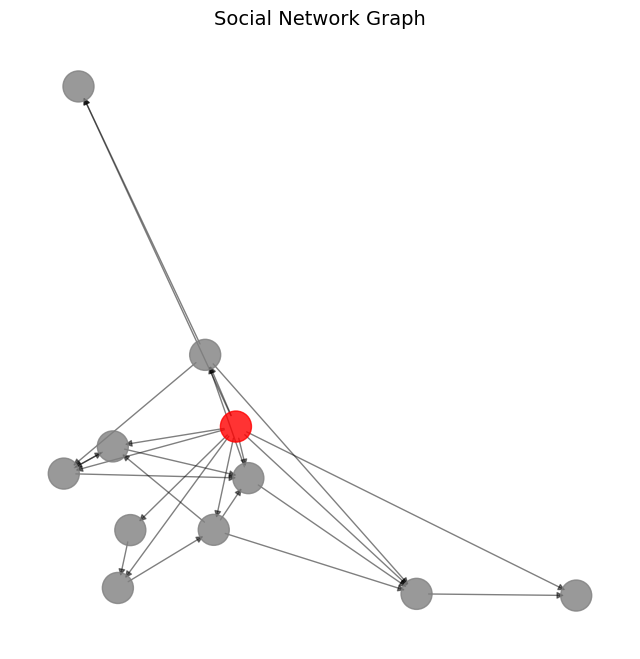

In [13]:
env = SocialNetworkEnv(numConsumer=10)
obs, _ = env.reset()
actions = np.random.choice([0, 1], size=(env.numConsumers))  # Random actions for each agent and neighbor
obs, rewards, done, info = env.step(actions)
print(obs, rewards, done, info)
env.render()

In [ ]:
# import gymnasium as gym
# from gymnasium import spaces
# import numpy as np
# import networkx as nx


# class SocialNetworkEnv(gym.Env):
#     """
#     Custom Environment for simulating a social network with agents of different types interacting.
#     """
#     def __init__(self, num_agents=10):
#         super(SocialNetworkEnv, self).__init__()
        
#         # Define the graph representing the network
#         self.graph = nx.DiGraph()
        
#         # Add nodes (agents) with attributes
#         for i in range(num_agents):
#             agent_type = np.random.choice(["real-information", "fake-information", "fact-checker", "consumer"])
#             self.graph.add_node(i, 
#                                 type=agent_type, 
#                                 qVal=0.0, 
#                                 trustLevel=1.0, 
#                                 storedInfo=[], 
#                                 reward=0, 
#                                 penalty=0)
        
#         # Add random edges (connections) with initial weights
#         for _ in range(num_agents * 2):  # Each agent connects with ~2 others
#             src = np.random.randint(0, num_agents)
#             dst = np.random.randint(0, num_agents)
#             if src != dst:
#                 self.graph.add_edge(src, dst, weight=1.0)
        
#         # Action and observation spaces
#         self.num_agents = num_agents
#         self.action_space = spaces.Discrete(2)  # Each agent can choose to propagate news (1) or not (0)
#         self.observation_space = spaces.Dict({
#             "trustLevels": spaces.Box(low=0, high=1, shape=(num_agents,), dtype=np.float32),
#             "qVals": spaces.Box(low=-np.inf, high=np.inf, shape=(num_agents,), dtype=np.float32),
#         })

#     def reset(self, seed=None, options=None):
#         super().reset(seed=seed)
        
#         # Reset agents
#         for node in self.graph.nodes:
#             self.graph.nodes[node]["qVal"] = 0.0
#             self.graph.nodes[node]["trustLevel"] = 1.0
#             self.graph.nodes[node]["storedInfo"] = []
#             self.graph.nodes[node]["reward"] = 0
#             self.graph.nodes[node]["penalty"] = 0
        
#         # Generate random trust levels for all agents
#         trustLevels = np.random.rand(self.num_agents)
        
#         # Return initial observation
#         return {"trustLevels": trustLevels, 
#                 "qVals": np.zeros(self.num_agents)}, {}

#     def step(self, actions):
#         """
#         Step function simulates one iteration of agents interacting in the graph.
#         Each agent decides whether to propagate news or not based on its Q-value and trust-level.
#         """
#         rewards = np.zeros(self.num_agents)
#         penalties = np.zeros(self.num_agents)
        
#         # Simulate actions for all agents
#         for node, action in enumerate(actions):
#             if action == 1:  # Propagate news
#                 for neighbor in self.graph.neighbors(node):
#                     neighbor_data = self.graph.nodes[neighbor]
                    
#                     # Update trust-level and stored-information based on the source
#                     if self.graph.nodes[node]["type"] == "fake-information":
#                         neighbor_data["trustLevel"] -= 0.1
#                     elif self.graph.nodes[node]["type"] == "real-information":
#                         neighbor_data["trustLevel"] += 0.1
                    
#                     neighbor_data["storedInfo"].append({
#                         "news": f"news_from_{node}",
#                         "source": node,
#                         "truthfulness": np.random.uniform(0, 100) if self.graph.nodes[node]["type"] == "fake-information" else np.random.uniform(50, 100)
#                     })
                    
#                     # Assign rewards/penalties
#                     if neighbor_data["type"] == "fact-checker":
#                         if neighbor_data["storedInfo"][-1]["truthfulness"] < 50:
#                             rewards[node] += 1  # Caught fake news
#                             penalties[node] += 1  # Penalize misinformation source
                    
#                     if neighbor_data["type"] == "consumer":
#                         rewards[node] += 0.5  # Influence gained

#         # Update Q-values for all nodes
#         for node in self.graph.nodes:
#             max_qVal = max(rewards[node] - penalties[node], 0)
#             self.graph.nodes[node]["qVal"] += 0.1 * (rewards[node] - penalties[node] + 0.9 * max_qVal - self.graph.nodes[node]["qVal"])
        
#         # Return the updated state
#         trustLevels = np.array([self.graph.nodes[i]["trustLevel"] for i in range(self.num_agents)])
#         qVals = np.array([self.graph.nodes[i]["qVal"] for i in range(self.num_agents)])
#         done = False  # In this simulation, the environment does not end
#         info = {}

#         return {"trustLevels": trustLevels, "qVals": qVals}, rewards, done, info

#     def render(self, mode="human"):
#         """
#         Optional: Render the graph for debugging or visualization.
#         """
#         if mode == "human":
#             print("Graph Nodes and Attributes:")
#             for node, data in self.graph.nodes(data=True):
#                 print(f"Node {node}: {data}")
#             print("Graph Edges:")
#             for src, dst, data in self.graph.edges(data=True):
#                 print(f"Edge {src} -> {dst}: {data}")


# env = SocialNetworkEnv(num_agents=10)
# obs, _ = env.reset()
# print(obs)
# actions = np.random.choice([0, 1], size=10)  # Random actions
# obs, rewards, done, info = env.step(actions)
# print(obs, rewards)
# env.render()


In [ ]:
# import networkx as nx
# import numpy as np
# import random

# class Agent:
#     def __init__(self, agent_type, trustLevel=0.5):
#         self.type = agent_type
#         self.trustLevel = trustLevel
#         self.qVals = {}  # Q-values: state-action pairs
#         self.history = []   # Store information received and actions taken
#         self.influence = 0  # Influence score for tracking performance

#     def choose_action(self, neighbors, epsilon=0.1):
#         if random.uniform(0, 1) < epsilon or not neighbors:
#             return random.choice(neighbors) if neighbors else None  # Explore
#         state = tuple(neighbors)
#         actions = self.qVals.get(state, {neighbor: 0 for neighbor in neighbors})
#         return max(actions, key=actions.get)  # Exploit

#     def update_qVal(self, state, action, reward, next_state, alpha=0.1, gamma=0.9):
#         max_next_q = max(self.qVals.get(next_state, {}).values(), default=0)
#         current_q = self.qVals.get(state, {}).get(action, 0)
#         self.qVals.setdefault(state, {})[action] = current_q + alpha * (reward + gamma * max_next_q - current_q)


# class SocialNetwork:
#     def __init__(self, num_agents, agent_distribution):
#         self.graph = nx.Graph()
#         self.agents = []

#         for i in range(num_agents):
#             agent_type = random.choices(list(agent_distribution.keys()), weights=list(agent_distribution.values()))[0]
#             agent = Agent(agent_type)
#             self.graph.add_node(i, agent=agent)
#             self.agents.append(agent)

#         # Randomly connect agents
#         for _ in range(num_agents * 2):  # Adjust for graph density
#             a, b = random.sample(range(num_agents), 2)
#             if not self.graph.has_edge(a, b):
#                 self.graph.add_edge(a, b, weight=random.uniform(0.1, 1.0))

#     def run_iteration(self, epsilon=0.1, alpha=0.1, gamma=0.9):
#         for node, data in self.graph.nodes(data=True):
#             agent = data['agent']
#             neighbors = list(self.graph.neighbors(node))
#             if not neighbors:
#                 continue

#             state = tuple(neighbors)
#             action = agent.choose_action(neighbors, epsilon)

#             # Simulate the action
#             reward, next_state = self.simulate_action(node, action)
#             agent.update_qVal(state, action, reward, next_state, alpha, gamma)

#     def simulate_action(self, node, action):
#         agent = self.graph.nodes[node]['agent']
#         target_agent = self.graph.nodes[action]['agent']

#         # Determine rewards based on agent types
#         if agent.type == "fake-information":
#             if target_agent.type == "fact-checker":
#                 # Fake-information agent penalized if caught
#                 reward = -1 if random.random() < 0.5 else 1
#             else:
#                 reward = 1  # Influence increased if news spreads
#             agent.influence += reward

#         elif agent.type == "real-information":
#             reward = 1  # Rewarded for spreading truthful information
#             agent.influence += reward

#         elif agent.type == "fact-checker":
#             if target_agent.type == "fake-information":
#                 reward = 1  # Reward for catching fake news
#             else:
#                 reward = -1  # Penalized for mislabeling
#             agent.influence += reward

#         else:  # Regular agents
#             reward = 0  # No reward or penalty for regular agents

#         # Update target agent trust level
#         trust_delta = 0.1 if reward > 0 else -0.1
#         target_agent.trustLevel = max(0, min(1, target_agent.trustLevel + trust_delta))

#         # New state is the updated neighbors list
#         next_state = tuple(self.graph.neighbors(node))
#         return reward, next_state

#     def evaluate(self):
#         influence_scores = [agent.influence for agent in self.agents]
#         return {
#             "average_influence": np.mean(influence_scores),
#             "max_influence": max(influence_scores),
#             "min_influence": min(influence_scores),
#         }


# # Example usage
# num_agents = 100
# agent_distribution = {
#     "real-information": 0.3,
#     "fake-information": 0.3,
#     "fact-checker": 0.2,
#     "regular": 0.2,
# }

# network = SocialNetwork(num_agents, agent_distribution)

# # Run 100 iterations
# for iteration in range(1000):
#     network.run_iteration()

# # Evaluate results
# results = network.evaluate()
# print("Simulation Results:")
# print(f"Average Influence: {results['average_influence']:.2f}")
# print(f"Max Influence: {results['max_influence']:.2f}")
# print(f"Min Influence: {results['min_influence']:.2f}")
